In [1]:
%cd ../
%pwd

D:\Projects\IndiaTB\IndTB_ppa


'D:\\Projects\\IndiaTB\\IndTB_ppa'

In [2]:
import numpy as np
import numpy.random as rd
import pandas as pd
import sims_pars as spr
from sims_pars.fitting import AbsObjectiveSimBased, ApproxBayesComSMC
from ppa import Shifting
from scipy.optimize import minimize_scalar
from scipy import linalg
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [3]:
dat = pd.read_csv('data/cascade/d_cascade_2019.csv')
dat = {row['State']: row for _, row in dat.iterrows()}
d = dat['India']

src_shf = pd.read_csv('data/shifting/shifting.csv')
shf = Shifting(src_shf, d.Pr_Pub_CSI)

In [4]:
Asym = 0
NotAware = 1
NotCS = 2
ExCS_pub = 3
ExCS_eng = 4
ExCS_pri = 5
ExCS = [ExCS_pub, ExCS_eng, ExCS_pri]
N_States = 6

In [5]:
class CascadeForward:
    def __init__(self, d, shf, pars):
        shf.update(pars)
        prev = d.PrevUt * 1e-5

        self.PrevA = prev * d['Pr_Asym']
        self.PrevS = prev * d['Pr_NotAware']
        self.PrevC = prev * d['Pr_NotCS']
        self.PrevE = prev * d['Pr_NotDet']

        self.R_Die_Asym = pars['r_die_asym']
        self.R_Die_Sym = pars['r_die_sym']
        self.R_SelfCure = pars['r_sc']
        
        self.IncR = inc = pars['inc']

        self.R_Onset = r_onset = inc / self.PrevA - (pars['r_die_asym'] + pars['r_sc'])
        mu = pars['r_die_sym'] + pars['r_sc']
        self.R_Aware = r_aware = r_onset * self.PrevA / self.PrevS - mu
        self.R_CSI = r_csi = r_aware * self.PrevS / self.PrevC - mu
        self.R_Det = r_det = r_csi * self.PrevC / self.PrevE - mu

        cs0 = r_csi * self.PrevC * shf.P_Entry
        fn0 = cs0 * (1 - shf.P_Dx0)
        det0 = cs0 * shf.P_Dx0

        self.P_Entry, self.P_Dx0 = shf.P_Entry, shf.P_Dx0
        self.P_Tr, self.P_Dx1 = trm, pdx1 = shf.P_Tr, shf.P_Dx1

        def fn(x, trm, pdx1, mu, fn0, exp_pe):
            pe = linalg.solve(x * (trm * (1 - pdx1)).T - np.eye(3) * (x + mu), -fn0)
            return (exp_pe - pe.sum()) ** 2

        opt = minimize_scalar(fn, args=(trm, pdx1, mu, fn0, self.PrevE, ), method = 'bounded', bounds=(0, 50))
        self.R_ReCSI = r_recsi = opt.x

        pe = linalg.solve(r_recsi * (trm * (1 - pdx1)).T - np.eye(3) * (r_recsi + mu), -fn0)

        self.PrevE_hs = pe
        self.DetR = det0 + (r_recsi * trm * pdx1 * pe).sum(0)
        
        self.P_TxI = np.array([d['TxI_pub'], d['TxI_eng'], pars['TxI_pri']])
        self.PPV = np.array([pars['ppv_pub'], pars['ppv_eng'], pars['ppv_pri']])
        
        self.DetR0 = self.DetR / self.PPV 
        self.TxR = self.DetR0 * self.P_TxI

        LTFU = np.array([d.TxLTFU_pub, d.TxLTFU_eng, d.TxLTFU_eng * pars['rr_ltfu_pri']])
        Succ = np.array([d.TxSucc_pub, d.TxSucc_eng, d.TxSucc_eng])
        Die = np.array([d.TxDead_pub, d.TxDead_eng, d.TxDead_eng])
        
        self.R_Succ_Tx = np.array([pars['r_succ_pub'], pars['r_succ_eng'], pars['r_succ_pri']])
        self.R_LTFU_Tx = self.R_Succ_Tx * LTFU / Succ
        self.R_Die_Tx = self.R_Succ_Tx * Die / Succ
        self.DurTx = 1 / (self.R_LTFU_Tx + self.R_Die_Tx + self.R_Succ_Tx)

        self.PrevTx = self.DetR * self.P_TxI * self.DurTx
        
        self.DrugTime = self.TxR * self.DurTx
        
        self.DataCNR = np.array([d.CNR_pub, d.CNR_eng, 0])
        
    def __call__(self, t, y):
        dy = np.zeros_like(y)
    
        onset = self.R_Onset * y[Asym] 
        aware = self.R_Aware * y[NotAware]
        csi = self.P_Entry * self.R_CSI * y[NotCS]
        det0 = self.P_Dx0 * csi
        fn0 = (1 - self.P_Dx0) * csi

        recsi = self.R_ReCSI * y[ExCS].reshape((-1, 1)) * self.P_Tr
        det1 = self.P_Dx1 * recsi
        fn1 = (1 - self.P_Dx1) * recsi

        det = det0 + det1.sum(0)

        dy[Asym] = det.sum() - onset
        dy[NotAware] = onset - aware
        dy[NotCS] = aware - csi.sum()
        dy[ExCS] = fn0 - recsi.sum(1) + fn1.sum(0)


        mu = np.zeros(N_States)
        mu[Asym] = self.R_Die_Asym + self.R_SelfCure
        mu[NotAware] = self.R_Die_Sym + self.R_SelfCure
        mu[NotCS] = self.R_Die_Sym + self.R_SelfCure
        mu[ExCS] = self.R_Die_Sym + self.R_SelfCure
        mu *= y

        dy -= mu
        dy[Asym] += mu.sum()

        return dy
 
    def get_y0(self):
        return np.concatenate([np.array([self.PrevA, self.PrevS, self.PrevC]), self.PrevE_hs])

In [6]:
prior = '''
PCore cascade {
    r_succ_pub = 2
    r_succ_eng = 2
    rr_ltfu_pri = 1.5
    ppv_pub = 0.85
    ppv_eng = 0.85
    ppv_pri ~ unif(0.1, ppv_eng)

    r_die_ut ~ unif(0.14, 0.18)
    r_sc ~ unif(0.1, 0.3)
    rr_die_asym ~ unif(0, 1)
    
    r_die_sym = r_die_ut
    r_die_asym = r_die_ut * rr_die_asym
    TxI_pri ~ unif(0.5, 1)

    dur_succ_pri ~ unif(2 / 12, 12 / 12)
    r_succ_pri = 1 / dur_succ_pri
    
    ppm ~ unif(0, 1)
    odds_pri ~ unif(0.5, 5)
    tr_pub_pub ~ unif(0, 1)
    tr_pri_pub ~ unif(0, 1)

    inc = 0.00193
}
'''
# ~ unif(0.00132, 0.00266)

class ObjRates(AbsObjectiveSimBased):
    def __init__(self, d, shf):
        AbsObjectiveSimBased.__init__(self, prior)
        self.Data = d
        self.Shifting = shf

    def simulate(self, pars):
        return CascadeForward(self.Data, self.Shifting, pars)

    def link_likelihood(self, sim):
        return - np.power(sim.DetR0[:2] / sim.DataCNR[:2] - 1, 2).sum()

In [7]:
obj = ObjRates(d, shf)

In [8]:
p0 = obj.sample_prior()

sim = obj.simulate(p0)

sim
np.power(sim.DetR[:2] / sim.DataCNR[:2] - 1, 2).sum()

1.0906777264068004

In [9]:
alg = ApproxBayesComSMC(max_round=50, n_collect=300, n_core=4, verbose=2)

In [11]:
alg.fit(obj)

06-06-2022 20:21:16 INFO: Initialising
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  38 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    2.7s finished
06-06-2022 20:21:21 INFO: Step to 1
06-06-2022 20:21:21 INFO: Round 0, ESS 300.00
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  58 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 293 out of 300 | elapsed:   12.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   12.5s finished
06-06-2022 20:21:35 INFO: Step to 2
06-06-2022 20:21:35 INFO: Round 1, ESS 270, Epsilon 1.3188, Acceptance 94.0%
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  92 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    6.7s finished
06-06-2022 20:21:44 INFO: Step to 3
06-06-2022 20:21:44 INFO: Round 

06-06-2022 20:24:15 INFO: Step to 25
06-06-2022 20:24:15 INFO: Round 24, ESS 242, Epsilon 0.2749, Acceptance 48.7%
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    3.7s finished
06-06-2022 20:24:20 INFO: Step to 26
06-06-2022 20:24:20 INFO: Round 25, ESS 217, Epsilon 0.2594, Acceptance 49.7%
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  84 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    3.7s finished
06-06-2022 20:24:26 INFO: Step to 27
06-06-2022 20:24:26 INFO: Round 26, ESS 196, Epsilon 0.2454, Acceptance 44.7%
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  92 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    4.3s finished
06-06-2022 20:24:32 INFO: Step to 28


[Parallel(n_jobs=4)]: Done  92 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    4.5s finished
06-06-2022 20:26:56 INFO: Step to 50
06-06-2022 20:26:56 INFO: Round 49, ESS 242, Epsilon 0.0652, Acceptance 22.3%
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  92 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 293 out of 300 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    4.5s finished
06-06-2022 20:27:02 INFO: Step to 51
06-06-2022 20:27:02 INFO: Round 50, ESS 217, Epsilon 0.0618, Acceptance 26.0%
06-06-2022 20:27:02 INFO: Collecting posteriors


In [12]:
post = alg.Collector.DF

In [13]:
post.columns

Index(['r_die_ut', 'r_sc', 'rr_die_asym', 'TxI_pri', 'dur_succ_pri', 'ppm',
       'odds_pri', 'tr_pub_pub', 'tr_pri_pub', 'ppv_pri', 'r_succ_pub',
       'r_succ_eng', 'rr_ltfu_pri', 'ppv_pub', 'ppv_eng', 'inc', 'r_die_sym',
       'r_die_asym', 'r_succ_pri', 'LogPrior', 'LogLikelihood',
       'LogPosterior'],
      dtype='object')

<AxesSubplot:>

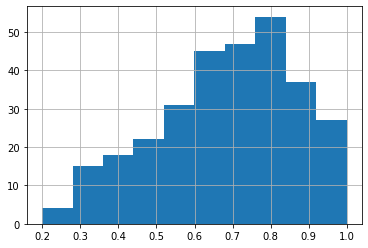

In [15]:
post.tr_pri_pub.hist()

<AxesSubplot:>

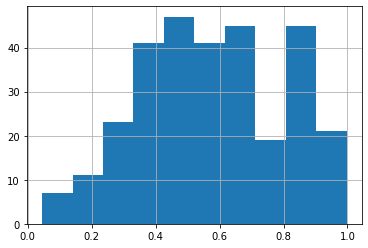

In [16]:
post.tr_pub_pub.hist()

<AxesSubplot:>

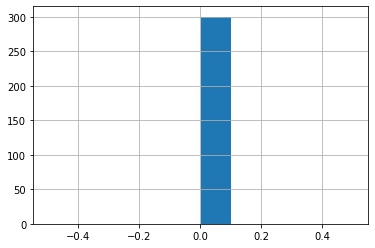

In [17]:
post.inc.hist()

In [18]:
pl = alg.Collector.ParameterList

In [19]:
cfs = [obj.simulate(p) for p in pl]

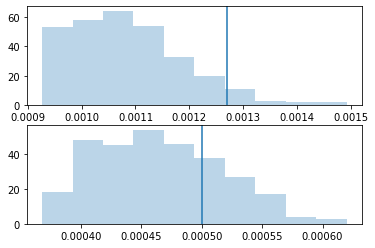

In [20]:
fig, axes = plt.subplots(2, 1)

axes[0].hist([cf.DetR0[0] for cf in cfs], alpha = 0.3)
axes[0].axvline(x=cfs[0].DataCNR[0])

axes[1].hist([cf.DetR0[1] for cf in cfs], alpha = 0.3)
axes[1].axvline(x=cfs[0].DataCNR[1])

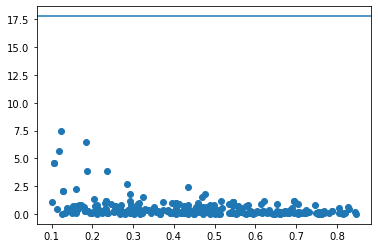

In [21]:
plt.scatter([cf.PPV[2] for cf in cfs], [cf.DrugTime[2] * 12 * d.N * 1e-6 for cf in cfs])
plt.axhline(y=17793 * 1e-3)

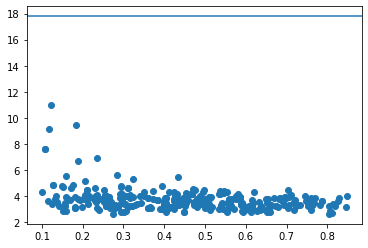

In [22]:
plt.scatter([cf.PPV[2] for cf in cfs], [cf.DrugTime[1:].sum() * 12 * d.N * 1e-6 for cf in cfs])
plt.axhline(y=17793 * 1e-3)

190.85494655813105

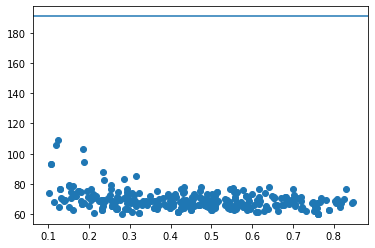

In [23]:
plt.scatter([cf.PPV[2] for cf in cfs], [cf.DrugTime.sum() * 1e5 for cf in cfs])
plt.axhline(y=d.PrevTx)

d.PrevTx 

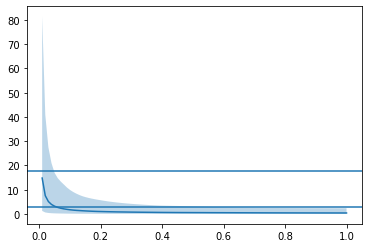

In [24]:
ppvs = np.linspace(0.01, 1, 99)

mss = list()
for ppv in ppvs:
    xs = np.array([(cf.DetR[2] / ppv * cf.DurTx[2] + cf.DrugTime[2]) * 12 for cf in cfs])
    mlu = np.quantile(xs, [0.05, 0.5, 0.95]) * d.N * 1e-6
    mss.append({
        'ppv': ppv,
        'm': mlu[1],
        'l': mlu[0],
        'u': mlu[2]
    })
    
mss = pd.DataFrame(mss)

plt.fill_between(mss.ppv, mss.l, mss.u, alpha = 0.3)
plt.plot(mss.ppv, mss.m)
plt.axhline(y=17793 * 1e-3)

plt.axhline(y=d.PrevTx * 1e-5 * d.N * 12 * 1e-7)

In [25]:
alg.Collector.save_to_csv(f'out/PostCasInd.csv')

In [26]:
def extract_rates(cf):
    return {
        'R_Die_Asym': cf.R_Die_Asym,
        'R_Die_Sym': cf.R_Die_Sym,
        'R_Die_Tx': cf.R_Die_Tx.tolist(),
        'R_SelfCure': cf.R_SelfCure,
        'R_Onset': cf.R_Onset,
        'R_Aware': cf.R_Aware,
        'R_CSI': cf.R_CSI,
        'R_ReCSI': cf.R_ReCSI,
        'P_Entry': cf.P_Entry.tolist(),
        'P_Tr': cf.P_Tr.tolist(),
        'P_Dx0': cf.P_Dx0.tolist(),
        'P_Dx1': cf.P_Dx1.tolist(),
        'P_TxI': cf.P_TxI.tolist(),
        'PPV': cf.PPV.tolist(),
        'R_Succ_Tx': cf.R_Succ_Tx.tolist(),
        'R_LTFU_Tx': cf.R_LTFU_Tx.tolist()    
    }


rates = [extract_rates(cf) for cf in cfs]

In [27]:
import json

with open('out/rate_valid/Rates.json', 'w') as f:
    json.dump(rates, f)